# Task 1: Preprocess and Explore the Data

## Objective
Load, clean, and understand the historical financial data for TSLA, BND, and SPY. This analysis will inform our modeling decisions in the next tasks.

### Assets
- **TSLA (Tesla)**: High-growth stock, high risk.
- **BND (Vanguard Total Bond Market ETF)**: Bond market tracking, low risk, stability.
- **SPY (S&P 500 ETF)**: Broad market exposure, moderate risk.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style="whitegrid")

## 1. Load and Clean the Data

The initial inspection showed that the CSVs have a "triple header" (Ticker name and empty Date labels in the first few rows). We need to filter those out and ensure numeric types.

In [3]:
data_path = "../data/processed"
assets = ["TSLA", "BND", "SPY"]

def load_and_clean(ticker, path):
    file_path = os.path.join(path, f"{ticker}_historical_data.csv")
    # Load data
    df = pd.read_csv(file_path)
    
    # 1. Filter out irrelevant records (redundant header rows)
    if 'Price' in df.columns:
        df = df[~df['Price'].isin(['Ticker', 'Date'])].copy()
        df.rename(columns={'Price': 'Date'}, inplace=True)
    
    # 2. Verify and convert data types
    df['Date'] = pd.to_datetime(df['Date'])
    for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 3. Remove duplicate records based on Date
    df = df.drop_duplicates(subset=['Date'])
    
    # 4. Handle missing values
    df = df.sort_values('Date')
    # Use linear interpolation for price gaps, then drop any remaining NaNs
    df = df.interpolate(method='linear')
    df.dropna(inplace=True)
    
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    
    return df

# Re-load and clean all dataframes
dfs = {asset: load_and_clean(asset, data_path) for asset in assets}

for asset, df in dfs.items():
    print(f"{asset} loaded and cleaned. Shape: {df.shape}")

TSLA loaded and cleaned. Shape: (2775, 5)
BND loaded and cleaned. Shape: (2775, 5)
SPY loaded and cleaned. Shape: (2775, 5)


## 2. Basic Inspection (Post-Cleaning)

In [10]:
for asset, df in dfs.items():
    print(f"\n--- {asset} Statistics ---")
    display(df.describe())


--- TSLA Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,138.472937,141.534064,135.271181,138.505925,1.108480e+08
std,131.682073,134.616345,128.668762,131.791350,7.145365e+07
min,9.578000,10.331333,9.403333,9.488000,1.062000e+07
25%,17.851666,18.087000,17.588000,17.836666,6.758150e+07
50%,91.625999,94.484001,89.113998,93.066666,9.264600e+07
75%,242.028336,247.846664,236.978333,242.901665,1.282366e+08
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08



--- BND Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,67.325728,67.424459,67.224864,67.328206,4.485148e+06
std,4.685294,4.692171,4.676260,4.685213,2.918896e+06
min,59.698631,59.772439,59.661729,59.728157,0.000000e+00
25%,63.436426,63.504392,63.370278,63.438516,2.172700e+06
50%,66.492111,66.634788,66.376242,66.478968,4.175700e+06
75%,71.237354,71.377835,71.094423,71.256967,6.043050e+06
max,76.068130,76.161647,76.034125,76.127648,3.396300e+07



--- SPY Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,339.074724,340.845874,337.015720,339.015876,8.604954e+07
std,141.925745,142.569517,141.139477,141.905190,4.386106e+07
min,154.980881,156.031833,152.881578,154.540157,2.027000e+07
25%,219.599663,221.038702,218.370034,219.349115,5.881420e+07
50%,301.538483,303.765169,299.861332,302.125017,7.570750e+07
75%,423.938461,425.885996,421.455155,423.759636,9.923995e+07
max,695.159973,696.090027,691.349976,695.489990,5.072443e+08


## 3. Exploratory Data Analysis (Visual Analysis)

### 3.1 Closing Price Trends
Visualizing the closing price over time to identify long-term trends.

## Descriptive Statistics

In [4]:
# Generate descriptive statistics for each asset
for asset in assets:
    print(f"\n--- {asset} Descriptive Statistics ---")
    display(dfs[asset].describe())


--- TSLA Descriptive Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,138.472937,141.534064,135.271181,138.505925,1.108480e+08
std,131.682073,134.616345,128.668762,131.791350,7.145365e+07
min,9.578000,10.331333,9.403333,9.488000,1.062000e+07
25%,17.851666,18.087000,17.588000,17.836666,6.758150e+07
50%,91.625999,94.484001,89.113998,93.066666,9.264600e+07
75%,242.028336,247.846664,236.978333,242.901665,1.282366e+08
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08



--- BND Descriptive Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,67.325728,67.424459,67.224864,67.328206,4.485148e+06
std,4.685294,4.692171,4.676260,4.685213,2.918896e+06
min,59.698631,59.772439,59.661729,59.728157,0.000000e+00
25%,63.436426,63.504392,63.370278,63.438516,2.172700e+06
50%,66.492111,66.634788,66.376242,66.478968,4.175700e+06
75%,71.237354,71.377835,71.094423,71.256967,6.043050e+06
max,76.068130,76.161647,76.034125,76.127648,3.396300e+07



--- SPY Descriptive Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,339.074724,340.845874,337.015720,339.015876,8.604954e+07
std,141.925745,142.569517,141.139477,141.905190,4.386106e+07
min,154.980881,156.031833,152.881578,154.540157,2.027000e+07
25%,219.599663,221.038702,218.370034,219.349115,5.881420e+07
50%,301.538483,303.765169,299.861332,302.125017,7.570750e+07
75%,423.938461,425.885996,421.455155,423.759636,9.923995e+07
max,695.159973,696.090027,691.349976,695.489990,5.072443e+08


## Time series visualization

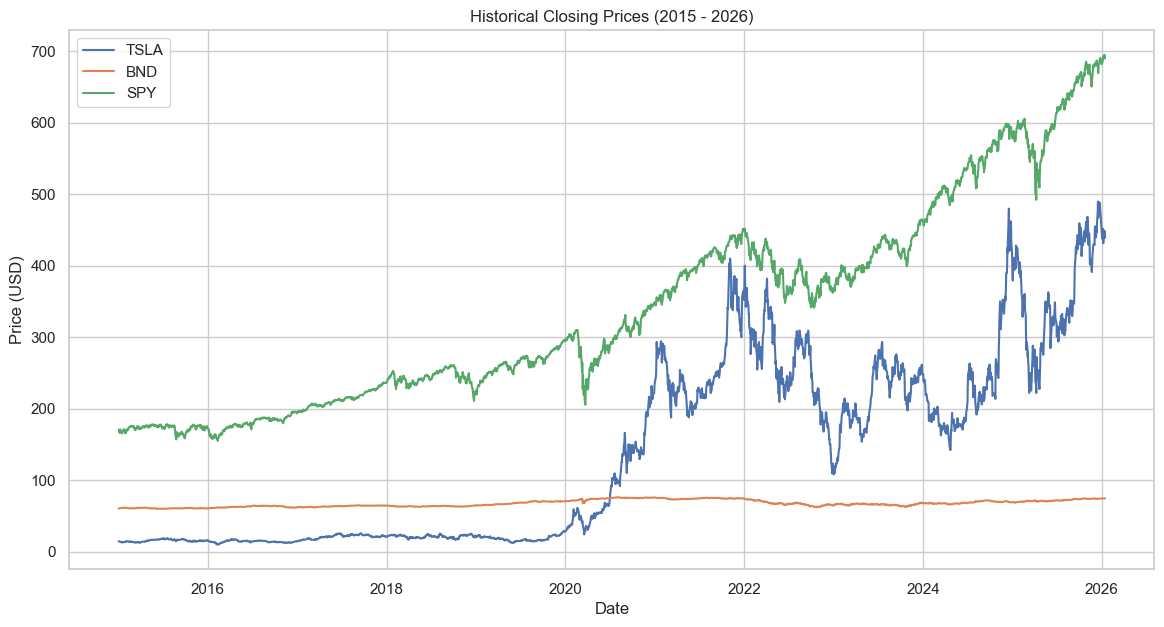

In [5]:
# Visualize closing price trends
plt.figure(figsize=(14, 7))
for asset in assets:
    plt.plot(dfs[asset].index, dfs[asset]['Close'], label=asset)

plt.title('Historical Closing Prices (2015 - 2026)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Volatility Analysis (Daily Returns)


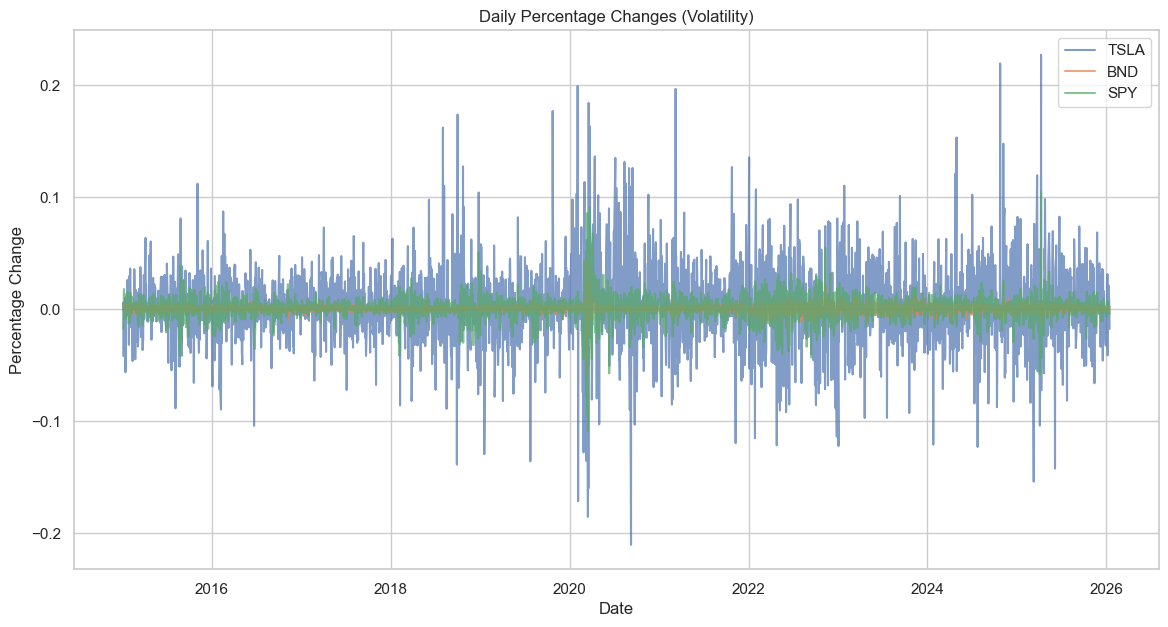

In [6]:
# Calculate and plot daily percentage changes
for asset in assets:
    dfs[asset]['Daily_Return'] = dfs[asset]['Close'].pct_change()
    dfs[asset].dropna(inplace=True)

plt.figure(figsize=(14, 7))
for asset in assets:
    plt.plot(dfs[asset].index, dfs[asset]['Daily_Return'], label=asset, alpha=0.7)

plt.title('Daily Percentage Changes (Volatility)')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

## Roolling Statistics

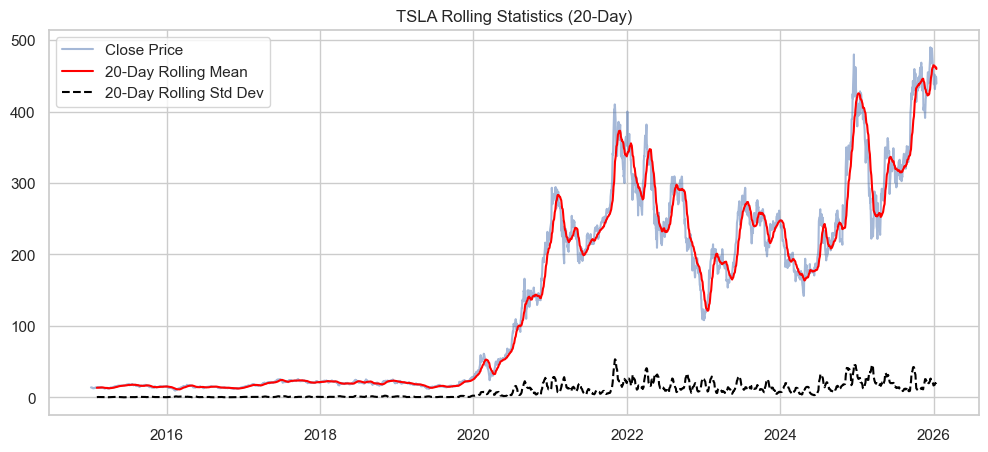

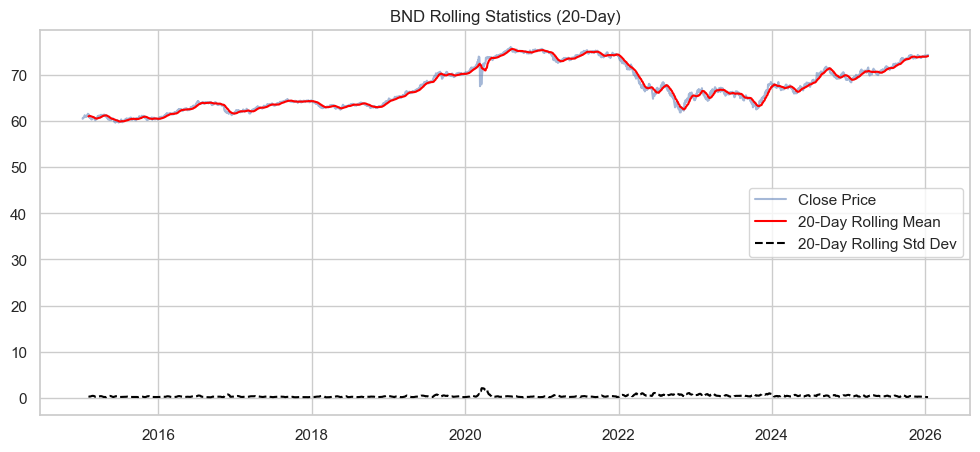

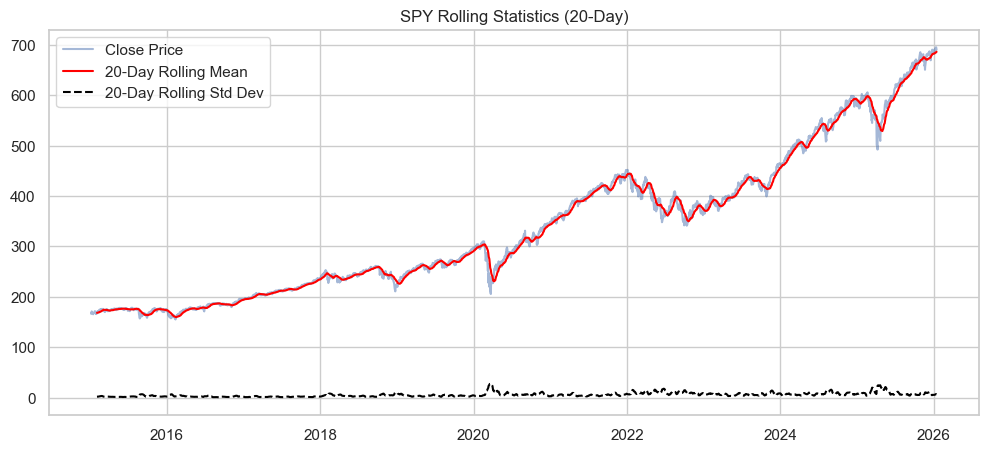

In [7]:
# Compute and visualize rolling mean and standard deviation (20-day window)
for asset in assets:
    df = dfs[asset]
    df['Rolling_Mean_20'] = df['Close'].rolling(window=20).mean()
    df['Rolling_Std_20'] = df['Close'].rolling(window=20).std()
    
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
    plt.plot(df.index, df['Rolling_Mean_20'], label='20-Day Rolling Mean', color='red')
    plt.plot(df.index, df['Rolling_Std_20'], label='20-Day Rolling Std Dev', color='black', linestyle='--')
    plt.title(f'{asset} Rolling Statistics (20-Day)')
    plt.legend()
    plt.show()

## Outlier detection

In [8]:
# Detect significant outliers (returns > 3 standard deviations from the mean)
for asset in assets:
    mean_ret = dfs[asset]['Daily_Return'].mean()
    std_ret = dfs[asset]['Daily_Return'].std()
    outliers = dfs[asset][(dfs[asset]['Daily_Return'] > mean_ret + 3*std_ret) | 
                          (dfs[asset]['Daily_Return'] < mean_ret - 3*std_ret)]
    
    print(f"\n--- {asset} Outlier Days ({len(outliers)}) ---")
    display(outliers[['Close', 'Daily_Return']].head())


--- TSLA Outlier Days (44) ---


,Close,Daily_Return
Date,,
2015-11-04,15.442000,0.111735
2018-08-02,23.302668,0.161880
2018-09-28,17.651333,-0.139015
2018-10-01,20.713333,0.173471
2018-10-23,19.609333,0.127189



--- BND Outlier Days (32) ---


,Close,Daily_Return
Date,,
2020-03-10,72.896523,-0.013444
2020-03-11,71.515892,-0.018940
2020-03-12,67.626488,-0.054385
2020-03-13,70.480392,0.042201
2020-03-16,71.221207,0.010511



--- SPY Outlier Days (39) ---


,Close,Daily_Return
Date,,
2015-08-24,158.832565,-0.042107
2015-08-26,162.989899,0.038394
2016-06-24,174.042526,-0.035909
2018-02-05,232.936539,-0.041823
2018-02-08,227.376373,-0.037509


## Stationarity Testing

- Run the Augmented Dickey-Fuller (ADF) test on closing prices and/or daily returns.
Document the test results, noting implications for model differencing if non-stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller

# Function to interpret ADF test results
def check_stationarity(series, title):
    print(f"\n--- ADF Test: {title} ---")
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    
    if result[1] < 0.05:
        print("Result: Stationary (Reject Null Hypothesis)")
        print("Implication: Series can be used directly for modeling (d=0).")
    else:
        print("Result: Non-Stationary (Fail to Reject Null Hypothesis)")
        print("Implication: Differencing is required for modeling (e.g., d=1).")

# Run tests for each asset
for asset in assets:
    print(f"\n{'='*10} Analyzing {asset} {'='*10}")
    
    # Test original Closing Prices
    check_stationarity(dfs[asset]['Close'], f"{asset} Close Price")
    
    # Test Daily Returns
    check_stationarity(dfs[asset]['Daily_Return'], f"{asset} Daily Return")


========== Analyzing TSLA ==========

--- ADF Test: TSLA Close Price ---
ADF Statistic: -0.7803
p-value: 0.8249
Result: Non-Stationary (Fail to Reject Null Hypothesis)
Implication: Differencing is required for modeling (e.g., d=1).

--- ADF Test: TSLA Daily Return ---
ADF Statistic: -53.0196
p-value: 0.0000
Result: Stationary (Reject Null Hypothesis)
Implication: Series can be used directly for modeling (d=0).

========== Analyzing BND ==========

--- ADF Test: BND Close Price ---
ADF Statistic: -1.0297
p-value: 0.7423
Result: Non-Stationary (Fail to Reject Null Hypothesis)
Implication: Differencing is required for modeling (e.g., d=1).

--- ADF Test: BND Daily Return ---
ADF Statistic: -10.4337
p-value: 0.0000
Result: Stationary (Reject Null Hypothesis)
Implication: Series can be used directly for modeling (d=0).

========== Analyzing SPY ==========

--- ADF Test: SPY Close Price ---
ADF Statistic: 1.1820
p-value: 0.9959
Result: Non-Stationary (Fail to Reject Null Hypothesis)
Implica

## Risk Metrics Calculation

- Compute Value at Risk (VaR) for each asset.
Calculate the Sharpe Ratio to assess risk-adjusted returns.

In [10]:
import numpy as np

# Annualization factor (assuming 252 trading days in a year)
TRADING_DAYS_PER_YEAR = 252

for asset in assets:
    df = dfs[asset]
    
    # 1. Value at Risk (VaR) at 95% confidence level
    # This represents the maximum expected loss on a day with 95% probability
    var_95 = np.percentile(df['Daily_Return'].dropna(), 5)
    
    # 2. Sharpe Ratio (Annualized)
    # Assuming risk-free rate of 0 for simplicity. 
    # Calculation: (Mean Daily Return / Std Dev Daily Return) * sqrt(252)
    daily_mean = df['Daily_Return'].mean()
    daily_std = df['Daily_Return'].std()
    
    sharpe_ratio = (daily_mean / daily_std) * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    print(f"\n--- {asset} Risk Metrics ---")
    print(f"Value at Risk (95% Confidence): {var_95:.4f}")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")


--- TSLA Risk Metrics ---
Value at Risk (95% Confidence): -0.0525
Annualized Sharpe Ratio: 0.8232

--- BND Risk Metrics ---
Value at Risk (95% Confidence): -0.0048
Annualized Sharpe Ratio: 0.3815

--- SPY Risk Metrics ---
Value at Risk (95% Confidence): -0.0167
Annualized Sharpe Ratio: 0.8040


## Documentation and Saving

- Save and document the processed data in the appropriate folder (e.g., data/processed).
Ensure all steps and findings are well documented in your Jupyter notebook.

In [11]:
import os

# Save the final processed data for each asset
# This data will be the starting point for Task 2 (Forecasting)
for asset in assets:
    output_filename = f"{asset}_final_processed.csv"
    output_file_path = os.path.join(data_path, output_filename)
    
    # Save to CSV
    dfs[asset].to_csv(output_file_path)
    print(f"Final processed data for {asset} saved to: {output_file_path}")

print("\n--- Task 1: Data Preprocessing and EDA Completed ---")

Final processed data for TSLA saved to: ../data/processed\TSLA_final_processed.csv
Final processed data for BND saved to: ../data/processed\BND_final_processed.csv
Final processed data for SPY saved to: ../data/processed\SPY_final_processed.csv

--- Task 1: Data Preprocessing and EDA Completed ---
